In [58]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
CAR_RATE = 3 # velocity of the car
TIME_CONST = 10000 #zoom in the time
RESOLUTION = 0.1

In [188]:
class road:
    def __init__(self, city, numOfCell=10, introRate=2, remvRate=2, direction = (0,1), startPos = (0,0)):
        #int numOfCell, int introRate, int remvRate, int index
        self.__introRate = introRate
        self.__remvRate = remvRate
        self.allCars = [] #cars in this road
        self.numOfCell = numOfCell
        self.passCar = 0 # number of the passing cars
        self.conflict = 0
        self.direction = direction
        self.startPos = startPos
        self.endPos = (startPos[0]+self.direction[0]*(self.numOfCell-1), startPos[1]+self.direction[1]*(self.numOfCell-1))
        #self.cell = {}  #cells in this road
        self.city = city
        for i in range(self.numOfCell):
            self.city.map[(self.startPos[0]+self.direction[0]*i, self.startPos[1]+self.direction[1]*i)] = 1
        
    def introCar(self,interval):
        # introduce a new car to this road
        if ((random.random() < self.__introRate*interval)&(self.city.map[self.startPos] == 1)):
            #print("new car!!!")
            self.city.map[self.startPos] = 2
            newCar = car(self)
            self.allCars.insert(0, newCar)
            
    def remvCar(self, interval):
        # remove the car in the last cell of this road
        if ((random.random() < self.__remvRate*interval)&(self.city.map[self.endPos] == 2)):
            self.city.map[self.endPos] = 1
            self.allCars.pop()
            self.passCar += 1
            
    def showCar(self):
        for i in range(self.numOfCell):
            if self.city.map[(self.startPos[0]+self.direction[0]*i, self.startPos[1]+self.direction[1]*i)] == 1:
                print(" | "+" ",end="")
            else:
                print(" | "+"*",end="")
        print(" |\n")

In [260]:
class car:
    def __init__(self, road, position=0, expClockRate=3, prob=0.5):
        #int position, int expClockRate, float prob, int index (which road)
        self.__position = (road.startPos[0]+road.direction[0]*position, road.startPos[1]+road.direction[1]*position)
        self.__expClockRate = expClockRate
        self.__prob = prob
        self.__road = road
    def moveForward(self, interval):
        if (random.random() < self.__expClockRate*interval)&(random.random() < self.__prob):
            # expo & not broken
            if (self.__road.city.map[(self.__position[0]+self.__road.direction[0], self.__position[1]+self.__road.direction[1])] == 1): # next cell is empty
                self.__road.city.map[self.__position] = 1
                self.__position = (self.__position[0]+self.__road.direction[0], self.__position[1]+self.__road.direction[1])
                self.__road.city.map[self.__position] = 2
            else:
                return "conflict"
        return "move"

In [261]:
class city:
    def __init__(self, l=100, w=100):
        self.l = l
        self.w = w
        self.map = {(i,j):0 for i in range(self.l) for j in range(self.w)} 
    def showMap():
        for aRoad in allRoads:
            

In [262]:
allRoads = []
intervals = []
Berkeley = city()
ourFirstRoad = road(Berkeley)
secondRoad = road(Berkeley, numOfCell=12, introRate=3, remvRate=5, direction = (1,0), startPos = (-5,0))
thirdRoad = road(Berkeley, numOfCell=10, introRate=4, remvRate=2, direction = (1,1), startPos = (-3,0))
allRoads.append(ourFirstRoad)
allRoads.append(secondRoad)
allRoads.append(thirdRoad)
startTime = time.time()
lastTime = startTime
Stop = False
while not Stop:
    #ourFirstRoad.showCar()
    currentTime = time.time()
    if currentTime -  startTime > 1:
        Stop = True
    interval = (currentTime - lastTime)*TIME_CONST # zoom in the time to simulate the actual case.
    intervals.append(interval)
    
    ourFirstRoad.introCar(interval)
    ourFirstRoad.remvCar(interval)
    secondRoad.introCar(interval)
    secondRoad.remvCar(interval)
    thirdRoad.introCar(interval)
    thirdRoad.remvCar(interval)
    for i in ourFirstRoad.allCars:
        ret = i.moveForward(interval)
        if ret =="conflict":
            ourFirstRoad.conflict += 1
    for j in secondRoad.allCars:
        ret = j.moveForward(interval)
        if ret =="conflict":
            secondRoad.conflict += 1
    for k in thirdRoad.allCars:
        ret = k.moveForward(interval)
        if ret =="conflict":
            thirdRoad.conflict += 1
    lastTime = currentTime

In [263]:
rx = []
ry = []
cx = []
cy = []
for i in Berkeley.map:
    if Berkeley.map[i] != 0:
        rx.append(i[0])
        ry.append(i[1])
    if Berkeley.map[i] == 2:
        cx.append(i[0])
        cy.append(i[1])

In [264]:
print(len(ourFirstRoad.allCars))

5


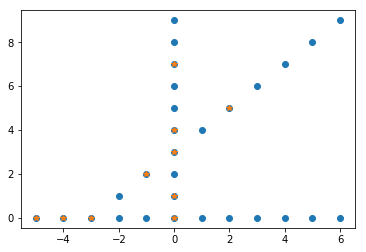

In [265]:
plt.plot(rx, ry, "o")
plt.plot(cx, cy, "*")
plt.show()

In [31]:
print(ourFirstRoad.passCar)

50


In [32]:
print(np.average(intervals))

32.83854526809499


In [1]:
[[[0]*2]*3]

[[[0, 0], [0, 0], [0, 0]]]

In [2]:
plot([[[0]*2]*3])

NameError: name 'plot' is not defined